In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from jeffutils.utils import p

# import an optimization thing that uses Newton's method to solve a function that evalutes to zero
from scipy.optimize import fsolve

# super simple case

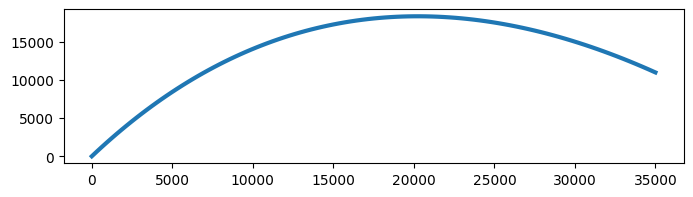

In [16]:
P_u = 9
P_l = 7
sigma2 = 1
Sx = 0
start_y = 0
forward_speed = 1
gravity = 9.8
Vx = 300
Vy = 600

# determine how long to run the BVP solver
t_span = (0, 100)
t_steps = 100
t, delta_t = np.linspace(t_span[0], t_span[1], t_steps, retstep=True)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    x, y, xp, yp = y_var
    ones = np.ones_like(xp)
    return np.array([
        xp,         # x' = x + delta_T*x'
        yp,         # y' = y + delta_T*y'  
        ones,                     # x'' = x'
        -gravity*ones    # y'' = y' - g*delta_T
    ])
def bc(ya, yb):
    return np.array([
        ya[0] - Sx,             # x(0) = Sx
        ya[1] - start_y,             # y(0) = Sy
        ya[2] - Vx,  # x'(0) = forward_speed
        ya[3] - Vy               # y'(0) = 0
    ])

# solve the bvp with the y0
y0 = np.ones((4, t_steps))
sol = solve_bvp(ode, bc, t, y0)

# extract the values from the solution
x = sol.y[0]
y = sol.y[1]
xp = sol.y[2]
yp = sol.y[3]

# plot the x(t)
plt.plot(x, y, linewidth=3)
plt.gcf().set_size_inches(8,2)
plt.show()

# sin composition

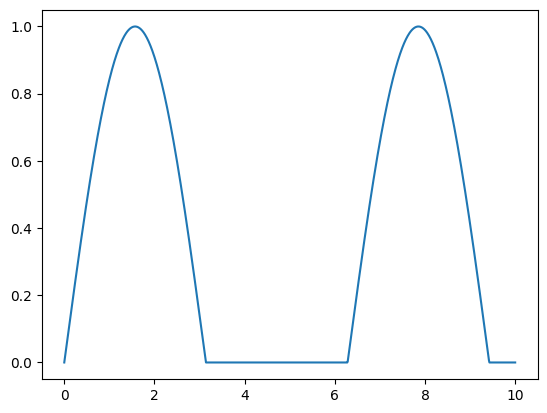

In [54]:
domain = np.linspace(0, 10, 1000)

plt.plot(domain, np.clip(np.sin(domain), 0, np.abs(np.sin(domain))))
plt.show()

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.47e-02       2.65e-06          100            15       
       2          1.23e-02       1.36e-08          115             6       
       3          6.40e-03       9.79e-10          121             5       
       4          2.81e-03       1.04e-11          126             5       
       5          1.32e-03       6.23e-13          131             3       
       6          9.72e-04       1.97e-14          134             0       
Solved in 6 iterations, number of nodes 134. 
Maximum relative residual: 9.72e-04 
Maximum boundary residual: 1.97e-14
The algorithm converged to the desired accuracy.


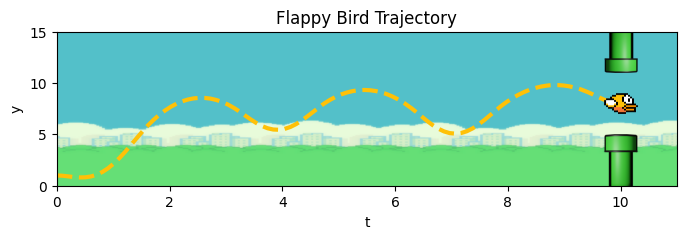

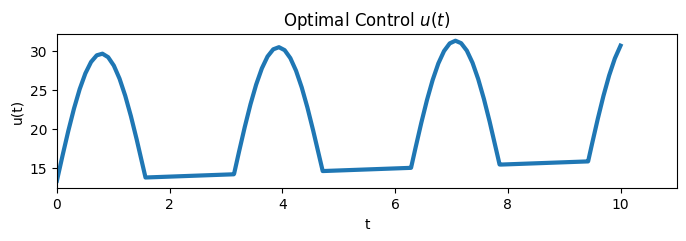

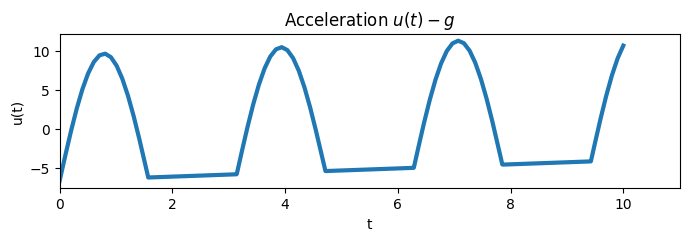

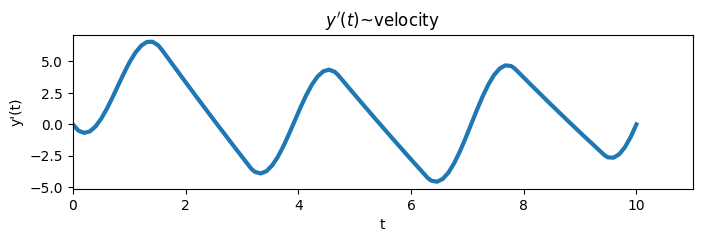

[13.4196523  16.6564342  19.76263848 22.6129986  25.09265406 27.10182229
 28.55985707 29.40852874 29.61439261 29.17014924 28.09494139 26.43357536
 24.25469859 21.64800752 18.72059931 15.59261584 13.99332479 13.89314242
 13.83050534 13.83215535 13.83545537 13.84205542 13.86845562 13.89485581
 13.92125601 13.9476562  13.9740564  14.00045659 14.02685679 14.05325698
 14.07965718 14.10605737 14.13245757 14.15885776 14.18525796 14.21165816
 14.23805835 14.23970836 14.31645379 14.72372289 15.53708724 17.15192946
 20.27727843 23.15913847 25.68136789 27.74245248 29.25963439 30.17227824
 30.44433737 30.06581994 29.0531954  27.44872456 25.31874075 22.75095174
 19.85087242 16.7375331  15.14060024 14.7399376  14.65221141 14.65386142
 14.66046147 14.68686167 14.71326186 14.73966206 14.76606225 14.79246245
 14.81886264 14.84526284 14.87166303 14.89806323 14.91126333 14.92446343
 14.93766352 14.95086362 14.97726382 15.00366401 15.03006421 15.0564644
 15.05976443 15.06141444 15.11142065 15.21325363 16.

In [124]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 10
pipe_l, pipe_u = 5, 11
sigma2 = 0.1**2
start_y = 1
g = 20
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (pipe_l+pipe_u)/2) * phi(y_tf)

alpha = 2
TAP_FORCE = 0.8*g

def control(p1, t):
    sin_part = np.sin(alpha*t)
    sin_part = np.clip(sin_part, 0, np.abs(sin_part))
    res = -p1/2 + TAP_FORCE*sin_part
    res = np.clip(res, 0, np.abs(res))
    return res

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    
    u = control(p1, t)
    #u = fsolve(lambda u: p1*np.cos(u) - np.cos(u), np.linspace(0, 2*np.pi, len(y)))
    #u = np.clip(u, 1, u)
    
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - start_y,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
    ])

# setup an intial guess for the solution
y_guess = np.linspace(start_y, (pipe_u+pipe_l)/2, t_steps)
yp_guess = np.ones(t_steps)*(((pipe_u+pipe_l)/2 - start_y) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.sin(8*np.linspace(t0, tf, t_steps))
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0, verbose=2)
print(sol.message)

# extract the values from the solution
t = sol.x
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
#u = fsolve(lambda u: p1*np.cos(u) - np.cos(u), np.linspace(0, 2*np.pi, len(y)))
u = control(p1, t)

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,2)
xlims = (0, tf+1)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
width = 0.3
xmin, xmax = tf-width, tf+width
ymin, ymax = pipe_u, ylims[1]
img = mpimg.imread('images/pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = tf-width, tf+width
ymin, ymax = ylims[0], pipe_l
img = mpimg.imread('images/pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = tf-width, tf+width
ymin, ymax = pipe_l+2, pipe_u-2
bird = mpimg.imread('images/bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# plot the u(t)
plt.title("Acceleration $u(t)-g$")
plt.plot(t, u - g, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# plot the velocity
plt.title("$y'(t)$~velocity")
plt.plot(t, yp, linewidth=3)
plt.xlabel("t")
plt.ylabel("y'(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

print(u)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 8.84e+00 
Maximum boundary residual: 2.33e+00
A singular Jacobian encountered when solving the collocation system.


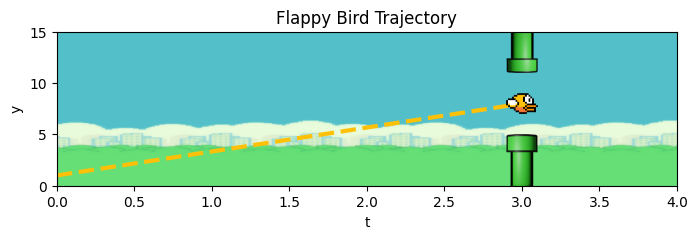

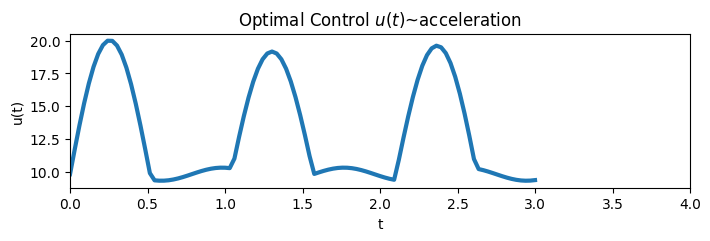

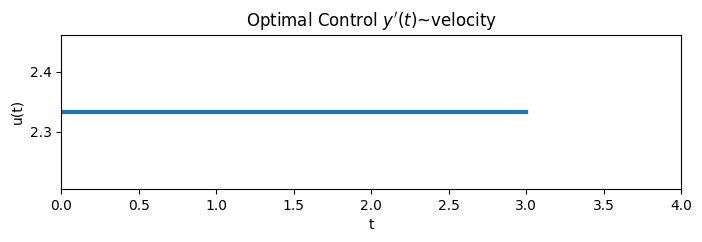

[ 9.8        11.69204556 13.5186537  15.2167234  16.72773885 17.9998469
 18.98968573 19.66389769 20.00027142 19.98847319 19.63034343 18.9397511
 17.94201592 16.67292433 15.17738042 13.50774635 11.72193717  9.88134361
  9.33010015  9.30282377  9.30462338  9.33539373  9.3933353   9.47505955
  9.57578704  9.68962701  9.80992185  9.92963643 10.04176958 10.1397635
 10.21788729 10.27157208 10.29767828 10.29467912 10.26275002 10.99132839
 12.66202779 14.2301807  15.64667691 16.8677338  17.85616924 18.58244771
 19.0254756  19.17312994 19.02251294 18.57993225 17.86061456 16.88816642
 15.69380225 14.31536465 12.79616648 11.18368752  9.81983979  9.93919346
 10.05040679 10.14697577 10.22325282 10.27477709 10.29853532 10.29313809
 10.25890103 10.1978264  10.11348598 10.0108122   9.89580965  9.77520393
  9.65604834  9.54531137  9.44946917  9.37412679 10.89373602 12.59440393
 14.21567842 15.70394284 17.00923086 18.08692651 18.89932774 19.41701639
 19.61998224 19.49845481 19.05340553 18.29669322 17.25

In [83]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 3
pipe_l, pipe_u = 5, 11
sigma2 = 0.1**2
start_y = 1
g = 9.8
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (pipe_l+pipe_u)/2) * phi(y_tf)

alpha = 6
TAP_FORCE = g

def control(p1, t):
    sin_part = np.sin(alpha*t)
    sin_part = np.clip(sin_part, 0, np.abs(sin_part))
    res = p1/2 + TAP_FORCE*sin_part + TAP_FORCE
    res = np.clip(res, 0, np.abs(res))
    return res

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    
    u = control(p0, t)
    #u = fsolve(lambda u: p1*np.cos(u) - np.cos(u), np.linspace(0, 2*np.pi, len(y)))
    #u = np.clip(u, 1, u)
    
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp + u,         # y' = y'
        - ones*g, # y'' = u - g
        ones,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - start_y,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
    ])

# setup an intial guess for the solution
y_guess = np.linspace(start_y, (pipe_u+pipe_l)/2, t_steps)
yp_guess = np.ones(t_steps)*(((pipe_u+pipe_l)/2 - start_y) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.sin(8*np.linspace(t0, tf, t_steps))
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0, max_nodes=30_000, verbose=2)
print(sol.message)

# extract the values from the solution
t = sol.x
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
#u = fsolve(lambda u: p1*np.cos(u) - np.cos(u), np.linspace(0, 2*np.pi, len(y)))
u = control(p1, t)

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,2)
xlims = (0, 4)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = pipe_u, ylims[1]
img = mpimg.imread('images/pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = ylims[0], pipe_l
img = mpimg.imread('images/pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = 2.9, 3.1
ymin, ymax = 7, 9
bird = mpimg.imread('images/bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$~acceleration")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# plot the velocity
plt.title("Optimal Control $y'(t)$~velocity")
plt.plot(t, yp, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

print(u)

# multiple pipes

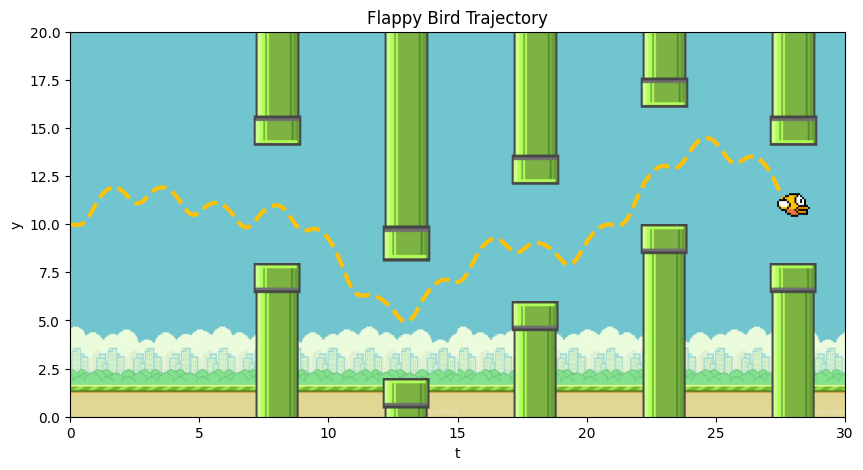

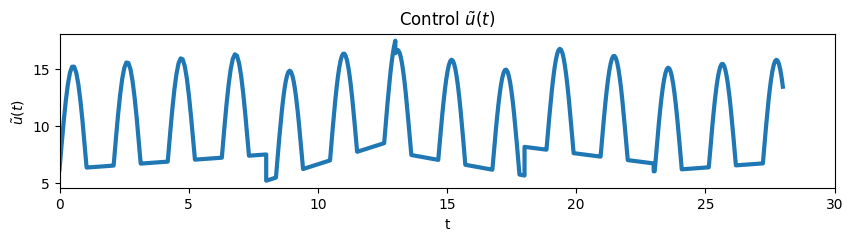

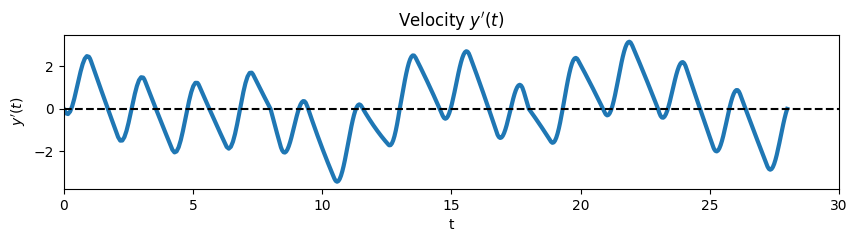

In [227]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

def get_sol(t0, tf, pipe_l, pipe_u, start_y, g=20, alpha=2, TAP_FORCE=0.8, sigma2=0.1**2, sine_weight=10, verbose=0):

    # determine how long to run the BVP solver
    t_steps = 100
    t = np.linspace(t0, tf, t_steps)

    # define the endpoint function and its derivative
    def phi(y_tf):
        return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
    def phi_d(y_tf):
        return (2/sigma2) * (y_tf - (pipe_l+pipe_u)/2) * phi(y_tf)

    # define the control relation to the co-state (comes from
    # the Lagrangian [u - sin(alpha t)]^2)
    def control(p1, t):
        sin_part = np.sin(alpha*t)
        sin_part = np.clip(sin_part, 0, np.abs(sin_part))
        res = -p1/2 + TAP_FORCE*sin_part
        res = np.clip(res, 0, np.abs(res))
        return res*sine_weight

    # setup the ode and boundary conditions for this problem
    def ode(t, y_var):
        y, yp, p0, p1 = y_var
        
        u = control(p1, t)
        
        zeros = np.zeros_like(y)
        ones = np.ones_like(y)
        return np.array([
            yp,         # y' = y'
            u - ones*g, # y'' = u - g
            zeros,      # p0' = -DH/Dy = 0
            -p0         # p1' = -DH/Dy' = -p0
        ])
    def bc(ya, yb):
        y_tf = yb[0]
        return np.array([
            ya[0] - start_y,         # y(0) = Sy
            ya[1] - 0,          # y'(0) = 0
            yb[1] - 0,          # y'(tf) = 0
            yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
        ])

    # setup an intial guess for the solution
    y_guess = np.linspace(start_y, (pipe_u+pipe_l)/2, t_steps)
    yp_guess = np.ones(t_steps)*(((pipe_u+pipe_l)/2 - start_y) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
    y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

    # solve the solution with the ode, bc, and initial guess
    sol = solve_bvp(ode, bc, t, y0, verbose=verbose)

    # extract the values from the solution
    t = sol.x
    y = sol.y[0]
    yp = sol.y[1]
    p0 = sol.y[2]
    p1 = sol.y[3]

    # compute the optimal control
    u = control(p1, t)
    
    return {'t':t, 'y':y, 'yp':yp, 'p0':p0, 'p1':p1, 'u':u, 'accel':u - g}

############################################################
#                     PLOT THE RESULTS                     #
############################################################

Y_PLOT_LIMS = (0, 20)
PIPE_GAP = 6
g = 9.8
alpha = 3
TAP_FORCE = 0.9
sine_weight = 10
sigma2 = 1**2

start_y = 10
pipe_ts = (np.arange(5)*5 + 8).tolist()
pipe_ls = [8, 2, 6, 10, 8]
pipe_us = [p + PIPE_GAP for p in pipe_ls]
times = [0] + pipe_ts

PIPE_WIDTH = (times[-1] - times[0]) / 30

curr_y = start_y
ts, ys, us, accels, velocities = [], [], [], [], []
for t0, tf, pipe_l, pipe_u in zip(times[:-1], times[1:], pipe_ls, pipe_us):
    
    sol = get_sol(
        t0, tf, pipe_l, pipe_u, curr_y, 
        g=g, alpha=alpha, TAP_FORCE=TAP_FORCE, 
        sigma2=sigma2, sine_weight=sine_weight)
    
    ts += sol['t'].tolist()
    ys += sol['y'].tolist()
    us += sol['u'].tolist()
    accels += sol['accel'].tolist()
    velocities += sol['yp'].tolist()
    
    curr_y = ys[-1]
    
PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(10,5)
xlims = (times[0], times[-1]+2)
ylims = Y_PLOT_LIMS
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(ts, ys, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/used/background.jpg')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the lower pipes
for pipe_t, pipe_l in zip(pipe_ts, pipe_ls):
    # load the image
    img = mpimg.imread('images/used/pipe_lower_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = ylims[0], pipe_l
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[:img_h, :, :]
    # add the iamge to the plot
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the upper pipes
for pipe_t, pipe_u in zip(pipe_ts, pipe_us):
    # load the image
    img = mpimg.imread('images/used/pipe_upper_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = pipe_u, ylims[1]
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[-img_h:, :, :]
    # add the iamge to the plot
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the bird
BIRD_SIZE = PIPE_WIDTH / 1.5
xmin, xmax = ts[-1]-BIRD_SIZE, ts[-1]+BIRD_SIZE
ymin, ymax = ys[-1]-BIRD_SIZE, ys[-1]+BIRD_SIZE
img = mpimg.imread('images/used/bird.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

plt.show()

plt.title(r"Control $\tilde{u}(t)$")
plt.gcf().set_size_inches(10,2)
xlims = (times[0], times[-1]+2)
plt.xlim(*xlims)
plt.xlabel("t")
plt.ylabel(r"$\tilde{u}(t)$")
plt.plot(ts, us, linewidth=3)
plt.show()

plt.title(r"Velocity $y'(t)$")
plt.gcf().set_size_inches(10,2)
xlims = (times[0], times[-1]+2)
plt.xlim(*xlims)
plt.xlabel("t")
plt.ylabel(r"$y'(t)$")
plt.plot(ts, velocities, linewidth=3)
plt.axhline(0, color='black', linestyle='--')
plt.show()

# plot the endpoint reward

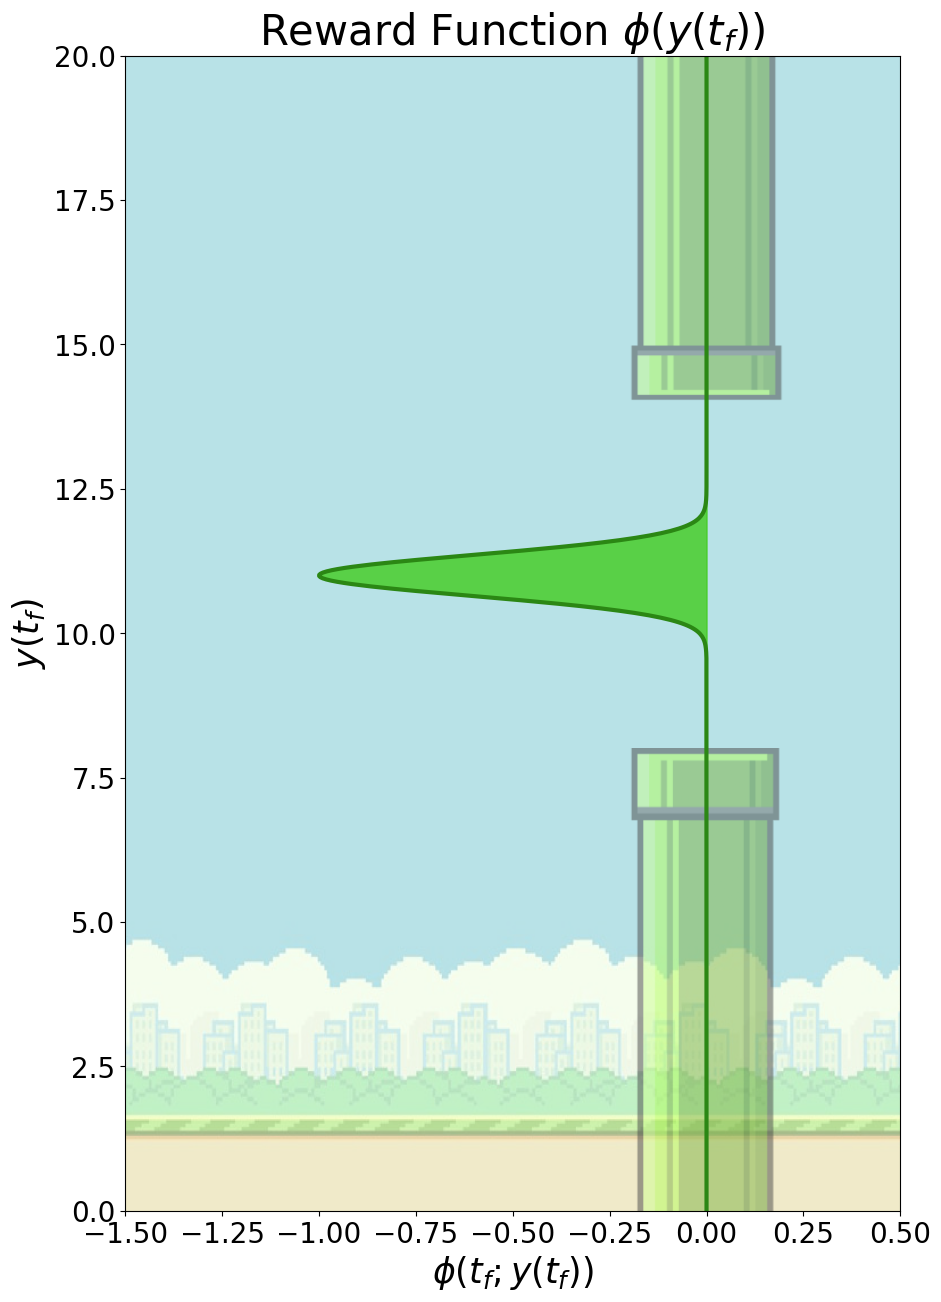

In [264]:
pipe_l = 8
pipe_u = 14
sigma2 = 0.5**2
def phi(y_tf):
    return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
ylims = (0, 20)
xlims = (-1.5, 0.5)
domain = np.linspace(ylims[0], ylims[-1], 1000)
xs = np.ones(1000)

bg_alpha = 0.5
pipe_alpha = 0.5

plt.xlim(*xlims)
plt.ylim(*ylims)
REWARD_COLOR = "#2b8714"
REWARD_COLOR_FILL = "#41cc1f"
plt.plot(phi(domain), domain, REWARD_COLOR, linewidth=3)
plt.fill_betweenx(domain, phi(domain), x2=0, color=REWARD_COLOR_FILL, alpha=0.8)

# plot the background
background = mpimg.imread('images/used/background.jpg')
h, w, c = background.shape
background = background[:, :int(w // 3), :]
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=alpha)

# plot the lower pipe
width = 0.2
xmin, xmax = 0-width, 0+width
ymin, ymax = ylims[0], pipe_l
img = mpimg.imread('images/used/pipe_lower_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

# plot the upper pipe
xmin, xmax = 0-width, 0+width
ymin, ymax = pipe_u, ylims[1]
img = mpimg.imread('images/used/pipe_upper_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

plt.gcf().set_size_inches(10, 15)
plt.title("Reward Function $\phi(y(t_f))$", fontsize=30)
plt.xlabel(r"$\phi(t_f ; y(t_f))$", fontsize=25)
plt.ylabel(r"$y(t_f)$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

# animation

In [3]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.ndimage import rotate
animation.writer = animation.writers['ffmpeg']


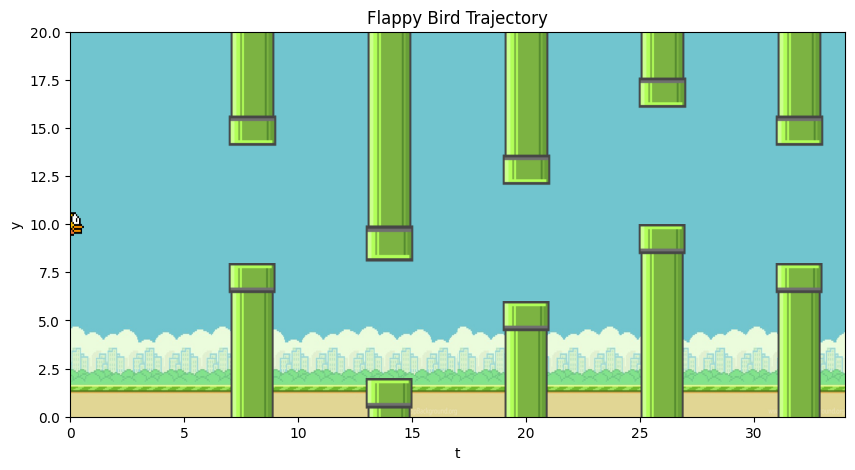

In [5]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

def get_sol(t0, tf, pipe_l, pipe_u, start_y, g=20, alpha=2, TAP_FORCE=0.8, sigma2=0.1**2, sine_weight=10, verbose=0):

    # determine how long to run the BVP solver
    t_steps = 100
    t = np.linspace(t0, tf, t_steps)

    # define the endpoint function and its derivative
    def phi(y_tf):
        return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
    def phi_d(y_tf):
        return (2/sigma2) * (y_tf - (pipe_l+pipe_u)/2) * phi(y_tf)

    # define the control relation to the co-state (comes from
    # the Lagrangian [u - sin(alpha t)]^2)
    def control(p1, t):
        sin_part = np.sin(alpha*t)
        sin_part = np.clip(sin_part, 0, np.abs(sin_part))
        res = -p1/2 + TAP_FORCE*sin_part
        res = np.clip(res, 0, np.abs(res))
        return res*sine_weight

    # setup the ode and boundary conditions for this problem
    def ode(t, y_var):
        y, yp, p0, p1 = y_var
        
        u = control(p1, t)
        
        zeros = np.zeros_like(y)
        ones = np.ones_like(y)
        return np.array([
            yp,         # y' = y'
            u - ones*g, # y'' = u - g
            zeros,      # p0' = -DH/Dy = 0
            -p0         # p1' = -DH/Dy' = -p0
        ])
    def bc(ya, yb):
        y_tf = yb[0]
        return np.array([
            ya[0] - start_y,         # y(0) = Sy
            ya[1] - 0,          # y'(0) = 0
            yb[1] - 0,          # y'(tf) = 0
            yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
        ])

    # setup an intial guess for the solution
    y_guess = np.linspace(start_y, (pipe_u+pipe_l)/2, t_steps)
    yp_guess = np.ones(t_steps)*(((pipe_u+pipe_l)/2 - start_y) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
    y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

    # solve the solution with the ode, bc, and initial guess
    sol = solve_bvp(ode, bc, t, y0, verbose=verbose)

    # extract the values from the solution
    t = sol.x
    y = sol.y[0]
    yp = sol.y[1]
    p0 = sol.y[2]
    p1 = sol.y[3]

    # compute the optimal control
    u = control(p1, t)
    
    return {'t':t, 'y':y, 'yp':yp, 'p0':p0, 'p1':p1, 'u':u, 'accel':u - g}

############################################################
#                     PLOT THE RESULTS                     #
############################################################

# setup all of the parameters for the problem
Y_PLOT_LIMS = (0, 20)
PIPE_GAP = 6
g = 9.8
alpha = 3
TAP_FORCE = 0.9
sine_weight = 10
sigma2 = 1**2

# set the starting location and the locations of the pipes
start_y = 10
pipe_ts = (np.arange(5)*6 + 8).tolist()
pipe_ls = [8, 2, 6, 10, 8]
pipe_us = [p + PIPE_GAP for p in pipe_ls]
times = [0] + pipe_ts

PIPE_WIDTH = (times[-1] - times[0]) / 30

# loop through each pipe getting a solution from pipe-to-pipe
curr_y = start_y
ts, ys, us, accels, velocities = [], [], [], [], []
for t0, tf, pipe_l, pipe_u in zip(times[:-1], times[1:], pipe_ls, pipe_us):
    
    # get the solution from the current location through the next pipe
    sol = get_sol(
        t0, tf, pipe_l, pipe_u, curr_y, 
        g=g, alpha=alpha, TAP_FORCE=TAP_FORCE, 
        sigma2=sigma2, sine_weight=sine_weight)
    
    # concatenate the solution into a full list
    ts += sol['t'].tolist()
    ys += sol['y'].tolist()
    us += sol['u'].tolist()
    accels += sol['accel'].tolist()
    velocities += sol['yp'].tolist()
    
    curr_y = ys[-1]
    
PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(10,5)
xlims = (times[0], times[-1]+2)
ylims = Y_PLOT_LIMS
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the background
background = mpimg.imread('images/used/background.jpg')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the lower pipes
for pipe_t, pipe_l in zip(pipe_ts, pipe_ls):
    # load the image
    img = mpimg.imread('images/used/pipe_lower_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = ylims[0], pipe_l
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[:img_h, :, :]
    # add the iamge to the plot
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the upper pipes
for pipe_t, pipe_u in zip(pipe_ts, pipe_us):
    # load the image
    img = mpimg.imread('images/used/pipe_upper_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = pipe_u, ylims[1]
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[-img_h:, :, :]
    # add the iamge to the plot
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the bird
BIRD_SIZE = PIPE_WIDTH / 1.75
xmin, xmax = ts[-1]-BIRD_SIZE, ts[-1]+BIRD_SIZE
ymin, ymax = ys[-1]-BIRD_SIZE, ys[-1]+BIRD_SIZE
img = mpimg.imread('images/used/bird.png')

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3, color=PATH_COLOR)

# Plot initial position of the bird
bird = plt.imshow(img, extent=[ts[0] - BIRD_SIZE, ts[0] + BIRD_SIZE, ys[0] - BIRD_SIZE, ys[0] + BIRD_SIZE], aspect='auto', zorder=2)

# Rotate bird image based on velocity
def rotate_bird(velocity):
    angle = np.degrees(np.arctan(velocity / 5))
    rotated_img = rotate(img, angle, reshape=False)
    rotated_img = np.clip(rotated_img, 0, 1)
    return rotated_img

# Define update function
def update(frame):
    print(frame, "/", len(ts), end="\r")
    # Update trajectory
    line.set_data(ts[:frame], ys[:frame])
    
    # Update bird position and rotation relative to velocity
    velocity = velocities[frame]
    bird.set_data(rotate_bird(velocity))
    
    # Update bird position
    bird.set_extent([ts[frame] - BIRD_SIZE, ts[frame] + BIRD_SIZE, ys[frame] - BIRD_SIZE, ys[frame] + BIRD_SIZE])

ani = FuncAnimation(plt.gcf(), update, frames=range(0, len(ts), 5), interval=60, repeat=False)
ani.save("images/animation.mp4")



# create smaller plots

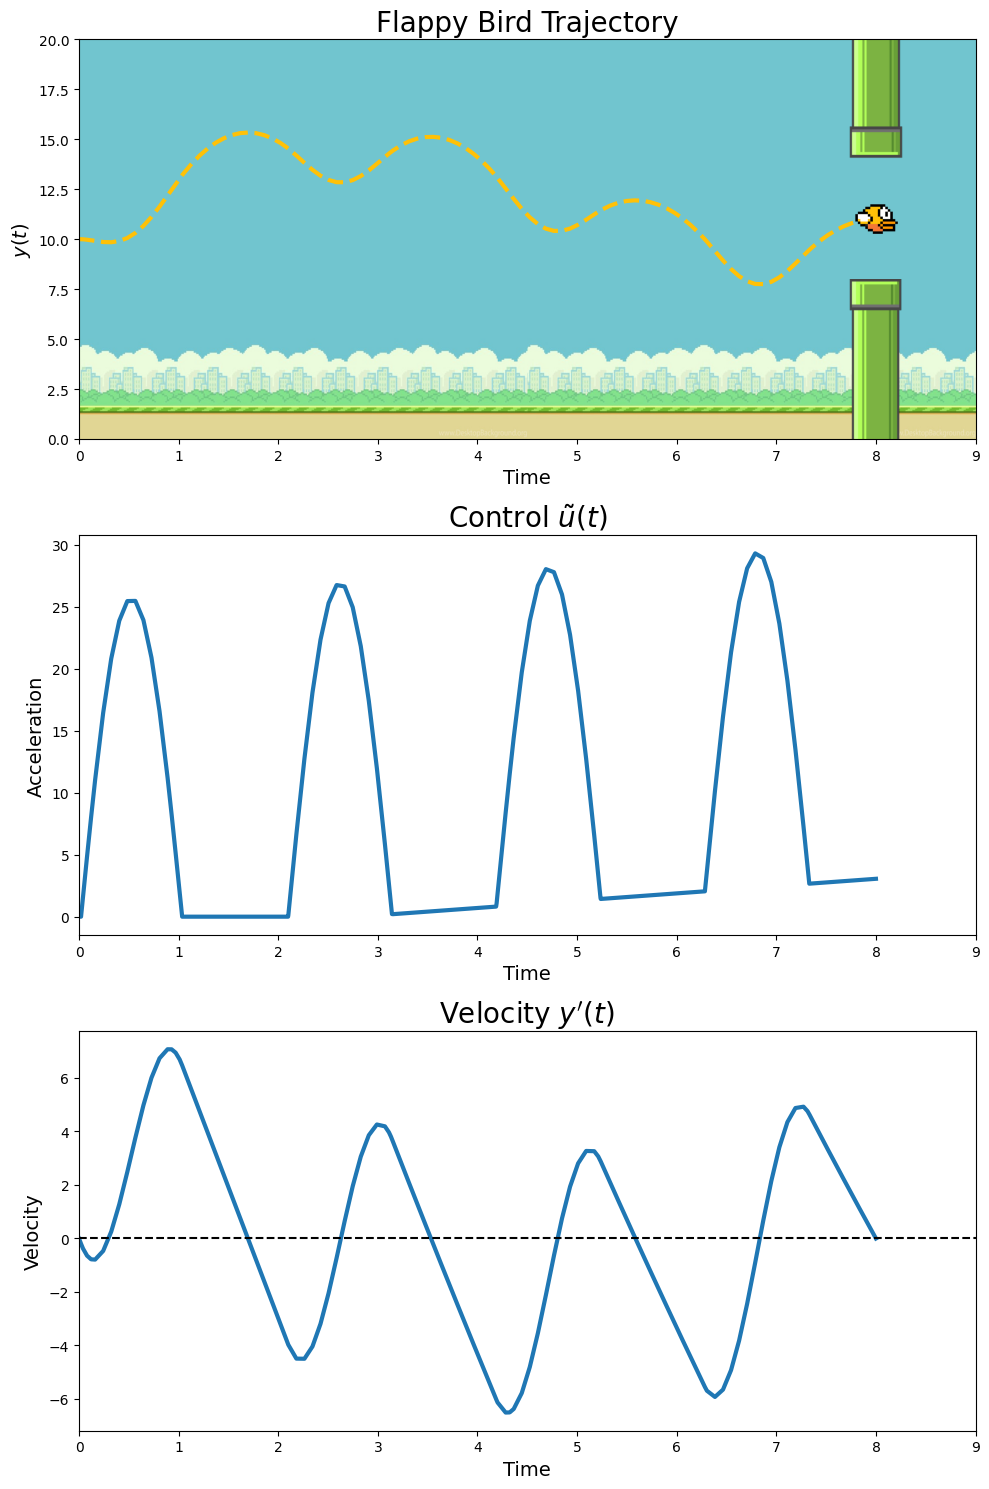

In [20]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

def get_sol(t0, tf, pipe_l, pipe_u, start_y, g=20, alpha=2, TAP_FORCE=0.8, sigma2=0.1**2, sine_weight=10, verbose=0):

    # determine how long to run the BVP solver
    t_steps = 100
    t = np.linspace(t0, tf, t_steps)

    # define the endpoint function and its derivative
    def phi(y_tf):
        return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
    def phi_d(y_tf):
        return (2/sigma2) * (y_tf - (pipe_l+pipe_u)/2) * phi(y_tf)

    # define the control relation to the co-state (comes from
    # the Lagrangian [u - sin(alpha t)]^2)
    def control(p1, t):
        sin_part = np.sin(alpha*t)
        sin_part = np.clip(sin_part, 0, np.abs(sin_part))
        res = -p1/2 + TAP_FORCE*sin_part
        res = np.clip(res, 0, np.abs(res))
        return res*sine_weight

    # setup the ode and boundary conditions for this problem
    def ode(t, y_var):
        y, yp, p0, p1 = y_var
        
        u = control(p1, t)
        
        zeros = np.zeros_like(y)
        ones = np.ones_like(y)
        return np.array([
            yp,         # y' = y'
            u - ones*g, # y'' = u - g
            zeros,      # p0' = -DH/Dy = 0
            -p0         # p1' = -DH/Dy' = -p0
        ])
    def bc(ya, yb):
        y_tf = yb[0]
        return np.array([
            ya[0] - start_y,         # y(0) = Sy
            ya[1] - 0,          # y'(0) = 0
            yb[1] - 0,          # y'(tf) = 0
            yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
        ])

    # setup an intial guess for the solution
    y_guess = np.linspace(start_y, (pipe_u+pipe_l)/2, t_steps)
    yp_guess = np.ones(t_steps)*(((pipe_u+pipe_l)/2 - start_y) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
    y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

    # solve the solution with the ode, bc, and initial guess
    sol = solve_bvp(ode, bc, t, y0, verbose=verbose)

    # extract the values from the solution
    t = sol.x
    y = sol.y[0]
    yp = sol.y[1]
    p0 = sol.y[2]
    p1 = sol.y[3]

    # compute the optimal control
    u = control(p1, t)
    
    return {'t':t, 'y':y, 'yp':yp, 'p0':p0, 'p1':p1, 'u':u, 'accel':u - g}

############################################################
#                     PLOT THE RESULTS                     #
############################################################

# setup parameters for the physics of the game
Y_PLOT_LIMS = (0, 20)
PIPE_GAP = 6
g = 9.8
alpha = 3
TAP_FORCE = 0.9
sine_weight = 30

# define the initial starting point and where the pipes are
start_y = 10
pipe_ls = [8]#, 2, 6, 10, 8]
pipe_ts = (np.arange(len(pipe_ls))*6 + 8).tolist()
pipe_us = [p + PIPE_GAP for p in pipe_ls]
times = [0] + pipe_ts

# compute a relative pipe width based on the time between pipes
PIPE_WIDTH = (times[-1] - times[0]) / 30

# compute the solution between each pair of pipes
curr_y = start_y
ts, ys, us, accels, velocities = [], [], [], [], []
for t0, tf, pipe_l, pipe_u in zip(times[:-1], times[1:], pipe_ls, pipe_us):
    
    # use solve_bvp to get the solution between these two pipes
    sol = get_sol(t0, tf, pipe_l, pipe_u, curr_y, 
                  g=g, alpha=alpha, TAP_FORCE=TAP_FORCE, 
                  sine_weight=sine_weight)
    
    # concatenate the results from this segment to the previous segments
    ts += sol['t'].tolist()
    ys += sol['y'].tolist()
    us += sol['u'].tolist()
    accels += sol['accel'].tolist()
    velocities += sol['yp'].tolist()
    
    # start the y where we left off
    curr_y = ys[-1]
    
PATH_COLOR = "#ffc107"

fig, axs = plt.subplots(3, 1, sharex=True)

# setup the plot
axs[0].set_title("Flappy Bird Trajectory", fontsize=20)
xlims = (times[0], times[-1]+1)
ylims = Y_PLOT_LIMS
axs[0].set_xlim(*xlims)
axs[0].set_ylim(*ylims)
axs[0].set_xlabel("Time", fontsize=14)
axs[0].set_ylabel("$y(t)$", fontsize=14)

# plot the trajectory
axs[0].plot(ts, ys, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/used/background.jpg')
axs[0].imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the lower pipes
for pipe_t, pipe_l in zip(pipe_ts, pipe_ls):
    # load the image
    img = mpimg.imread('images/used/pipe_lower_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = ylims[0], pipe_l
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[:img_h, :, :]
    # add the iamge to the plot
    axs[0].imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the upper pipes
for pipe_t, pipe_u in zip(pipe_ts, pipe_us):
    # load the image
    img = mpimg.imread('images/used/pipe_upper_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = pipe_u, ylims[1]
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[-img_h:, :, :]
    # add the iamge to the plot
    axs[0].imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the bird
BIRD_SIZE = PIPE_WIDTH / 1.25
hx = 3.5
xmin, xmax = ts[-1]-BIRD_SIZE, ts[-1]+BIRD_SIZE
ymin, ymax = ys[-1]-BIRD_SIZE*hx, ys[-1]+BIRD_SIZE*hx
img = mpimg.imread('images/used/bird.png')
axs[0].imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

'''# make the background transparent and the axis invisible
plt.gcf().patch.set_alpha(0)

# set the axis splines to be invisible
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# make the title and labels and ticks white and larger font
plt.title("Flappy Bird Trajectory", color="black", fontsize=20)
plt.xlabel("t", color="black", fontsize=20)
plt.ylabel("y", color="black", fontsize=20)
plt.xticks(color="black", fontsize=20)
plt.yticks(color="black", fontsize=20)
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')'''

# plot the control verses time plot
axs[1].set_title(r"Control $\tilde{u}(t)$", fontsize=20)
xlims = (times[0], times[-1]+2)
axs[1].set_xlabel("Time", fontsize=14)
axs[1].set_ylabel("Acceleration", fontsize=14)
axs[1].plot(ts, us, linewidth=3)

# plot the velocity verses time plot with a horizontal line at 0
axs[2].set_title(r"Velocity $y'(t)$", fontsize=20)
xlims = (times[0], times[-1]+2)
axs[2].set_xlabel("Time", fontsize=14)
axs[2].set_ylabel("Velocity", fontsize=14)
axs[2].plot(ts, velocities, linewidth=3)
axs[2].axhline(0, color='black', linestyle='--')

for ax in axs:
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)


fig.set_size_inches(10,15)
plt.tight_layout()
plt.savefig("images/poster/traj_con_vel.png", dpi=600, bbox_inches="tight")

plt.show()

In [ ]:



############################################################
#                    CODE AND/OR FIGURES                   #
############################################################
